# Multi agent logistics

In [2]:
# %pip install -U langchain langchain_openai langsmith pandas langchain_experimental

In [3]:
import os
import openai
from dotenv import load_dotenv

if load_dotenv():
    print("Found Azure OpenAI Endpoint: " + os.getenv("AZURE_OPENAI_ENDPOINT"))
else: 
    print("No file .env found")

Found Azure OpenAI Endpoint: https://dzeast4model.openai.azure.com/


create agents

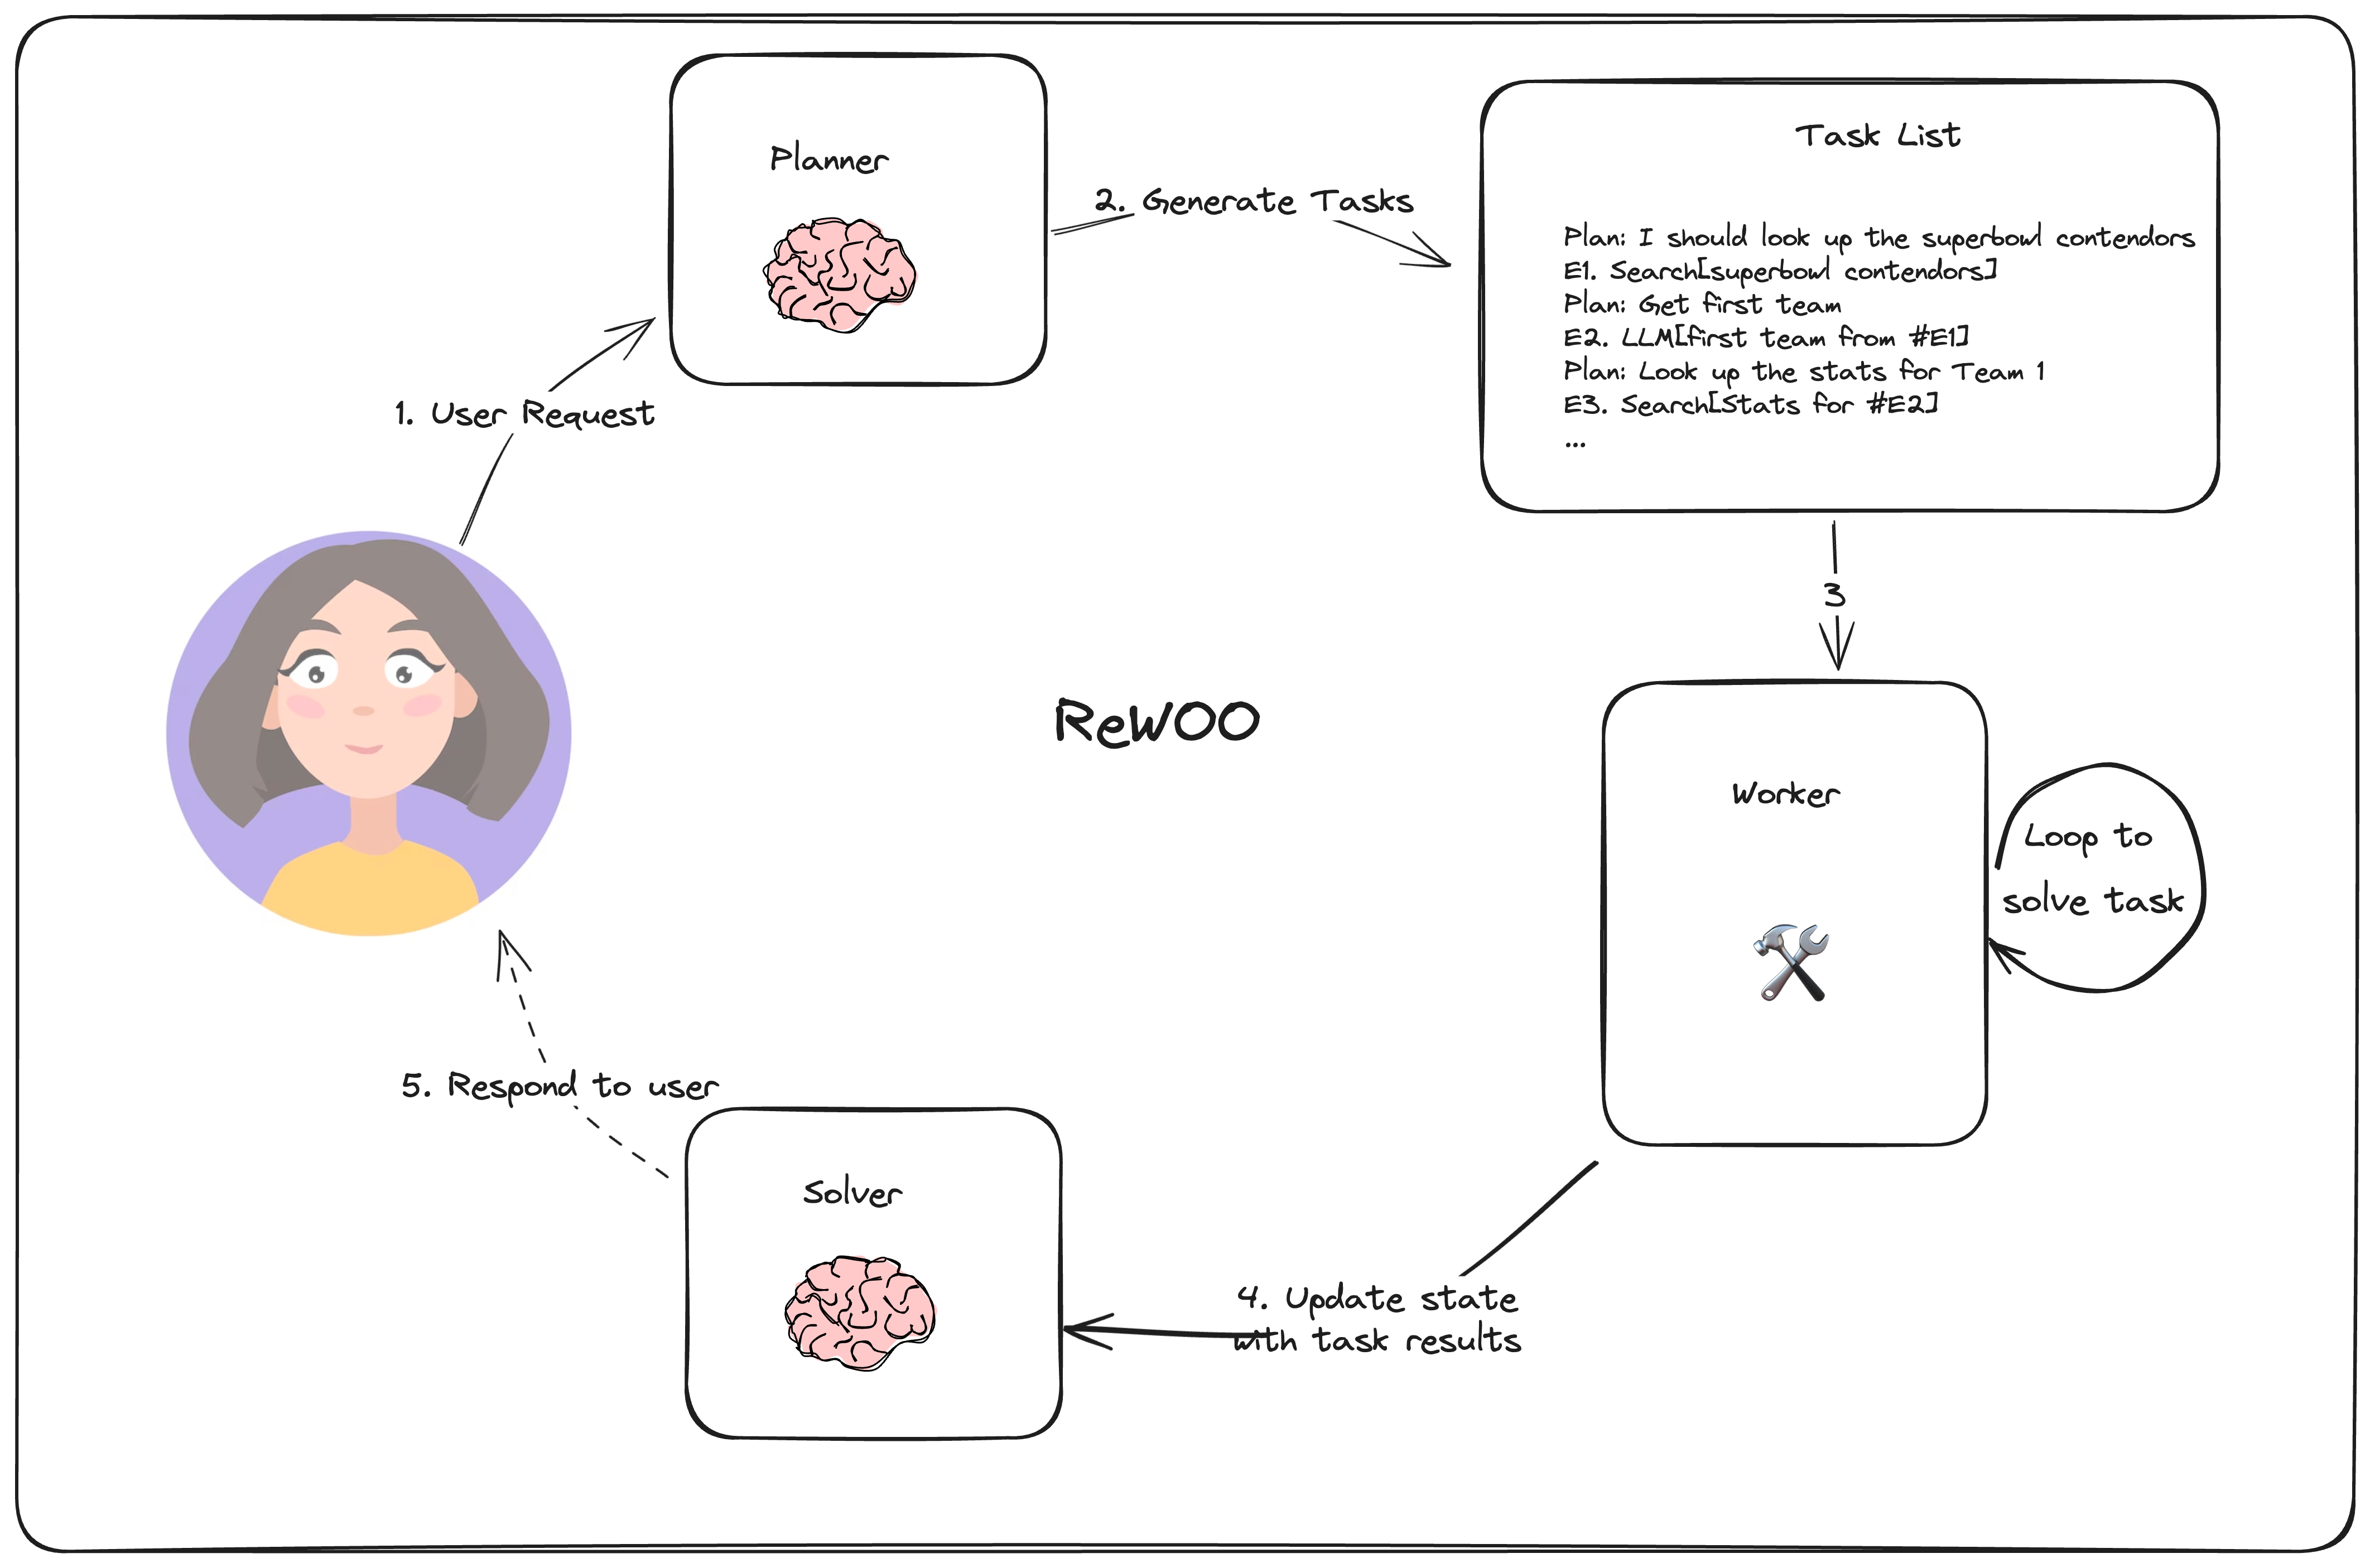

In [4]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.llms import AzureOpenAI
from langchain_openai import AzureChatOpenAI
from langchain.schema import HumanMessage

llm = AzureChatOpenAI(
    azure_deployment = os.getenv("AZURE_OPENAI_COMPLETION_DEPLOYMENT_NAME")
)

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an logistic assistant tasked with planning efficient box packing for a warehouse."
            " Generate the best packaging plan. "
            " If the user provides critique, respond with a revised version of your previous attempts.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

generate = prompt | llm

In [6]:
plan = ""

request = HumanMessage(
    content="Explain step by step. How many iPhones can fit in a 30cm x 30cm x 30cm box?"
)
for chunk in generate.stream({"messages": [request]}):
    print(chunk.content, end="")
    plan += chunk.content

To determine how many iPhones can fit in a 30cm x 30cm x 30cm box, we need to know the dimensions of the iPhone model we are trying to pack. For the sake of this example, let's assume we are dealing with the iPhone 13 Pro, which has dimensions of approximately 146.7mm (height) x 71.5mm (width) x 7.65mm (depth).

First, we need to convert the iPhone dimensions from millimeters to centimeters, as our box dimensions are given in centimeters:

- iPhone 13 Pro height: 146.7mm = 14.67cm
- iPhone 13 Pro width: 71.5mm = 7.15cm
- iPhone 13 Pro depth: 7.65mm = 0.765cm

Next, we need to calculate how many iPhones can fit along each dimension of the box:

- Along the 30cm height: 30cm / 14.67cm = approximately 2 iPhones (because you cannot fit a fraction of an iPhone, and the remaining space might not be enough for an additional layer).
- Along the 30cm width: 30cm / 7.15cm = approximately 4 iPhones
- Along the 30cm depth: 30cm / 0.765cm = approximately 39 iPhones

However, we cannot simply multip

In [7]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert planner. Generate critique and recommendations for the user's submission."
            " Provide detailed recommendations, including efficiency and safety considerations.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
reflect = reflection_prompt | llm

In [8]:
reflection = ""
for chunk in reflect.stream({"messages": [request, HumanMessage(content=plan)]}):
    print(chunk.content, end="")
    reflection += chunk.content

Critique:
The user's submission provides a logical approach to determining how many iPhones can fit in the specified box. However, there are several considerations and potential issues with the analysis that need to be addressed:

1. **Practicality and Safety**: The calculation does not take into account the need for protective packaging. iPhones would not be packed without protection as they are fragile electronic devices. Thus, the actual number of iPhones that can fit within the box would be reduced to allow for padding and to prevent damage during transit.

2. **Packaging Material**: The user did not specify the type of packaging material or the thickness of the protective layers, which is crucial for an accurate assessment. The inclusion of materials such as bubble wrap, foam inserts, or cardboard dividers will consume additional space within the box.

3. **Stacking Method**: The submission assumes that stacking iPhones in 39 layers is practical. In reality, such a tall stack woul

In [9]:
for chunk in generate.stream(
    {"messages": [request, AIMessage(content=plan), HumanMessage(content=reflection)]}
):
    print(chunk.content, end="")

Thank you for the thorough critique. Based on these considerations, let's revise the packaging plan to include protective packaging, ensure stability, and optimize the arrangement, while also being mindful of shipping regulations and environmental considerations.

1. **Protective Packaging**: Assume we will use foam inserts that are 0.5cm thick on all sides of the iPhone for protection. This increases the effective dimensions of each iPhone as follows:

    - iPhone 13 Pro height with foam: 14.67cm + 0.5cm + 0.5cm = 15.67cm
    - iPhone 13 Pro width with foam: 7.15cm + 0.5cm + 0.5cm = 8.15cm
    - iPhone 13 Pro depth with foam: 0.765cm + 0.5cm + 0.5cm = 1.765cm

2. **Stability**: To increase stability, we will avoid stacking the iPhones too high. We'll aim for a more conservative and stable stack height within the box.

3. **Efficiency and Arrangement**: We will place the iPhones in layers, oriented to maximize space usage without compromising on the protective padding.

    - Number o

In [10]:
from typing import List, Sequence

from langgraph.graph import END, MessageGraph


async def generation_node(state: Sequence[BaseMessage]):
    return await generate.ainvoke({"messages": state})


async def reflection_node(messages: Sequence[BaseMessage]) -> List[BaseMessage]:
    # Other messages we need to adjust
    cls_map = {"ai": HumanMessage, "human": AIMessage}
    # First message is the original user request. We hold it the same for all nodes
    translated = [messages[0]] + [
        cls_map[msg.type](content=msg.content) for msg in messages[1:]
    ]
    res = await reflect.ainvoke({"messages": translated})
    # We treat the output of this as human feedback for the generator
    return HumanMessage(content=res.content)


builder = MessageGraph()
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.set_entry_point("generate")


def should_continue(state: List[BaseMessage]):
    if len(state) > 6:
        # End after 3 iterations
        return END
    return "reflect"


builder.add_conditional_edges("generate", should_continue)
builder.add_edge("reflect", "generate")
graph = builder.compile()

In [11]:
async for event in graph.astream(
    [
        HumanMessage(
            content="Generate a plan on how to package 10 iPhones in a 30cm x 30cm x 30cm box."
        )
    ],
):
    print(event)
    print("---")

{'generate': AIMessage(content="To create an efficient packaging plan for 10 iPhones in a 30cm x 30cm x 30cm box, we need to consider the dimensions of a typical iPhone box. Assuming we are dealing with the iPhone 13, which has a box dimension of approximately 15.1cm x 7.6cm x 3.2cm, here's a plan:\n\n1. **Orientation**: Position the iPhone boxes flat on their largest face to maximize stability and minimize movement within the larger box.\n2. **Layering**: Since the iPhone box's smallest dimension is 3.2cm, we can stack them in layers within the 30cm height of the larger box.\n3. **Arrangement**: Place the iPhone boxes side by side in a 2x3 grid for each layer. This means two iPhone boxes in width (15.1cm x 2 = 30.2cm, which is a tight fit but often the boxes can be gently squeezed into the space) and three in length (7.6cm x 3 = 22.8cm), leaving some room to spare for protective padding.\n4. **Padding**: Use the remaining space (30cm - 22.8cm = 7.2cm lengthwise) for padding and protec

In [12]:
ChatPromptTemplate.from_messages(event[END]).pretty_print()

================================ Human Message =================================

Generate a plan on how to package 10 iPhones in a 30cm x 30cm x 30cm box.

================================== Ai Message ==================================

To create an efficient packaging plan for 10 iPhones in a 30cm x 30cm x 30cm box, we need to consider the dimensions of a typical iPhone box. Assuming we are dealing with the iPhone 13, which has a box dimension of approximately 15.1cm x 7.6cm x 3.2cm, here's a plan:

1. **Orientation**: Position the iPhone boxes flat on their largest face to maximize stability and minimize movement within the larger box.
2. **Layering**: Since the iPhone box's smallest dimension is 3.2cm, we can stack them in layers within the 30cm height of the larger box.
3. **Arrangement**: Place the iPhone boxes side by side in a 2x3 grid for each layer. This means two iPhone boxes in width (15.1cm x 2 = 30.2cm, which is a tight fit but often the boxes can be gently squeezed into